
# **Задачі в NLP**

Протягом цього завдання ми побачимо різні способи обробки послідовних даних, а саме як деякі шари Keras, такі як `GRU`, `Conv` та `LSTM`, можуть використовуватися для вирішення проблем у цій області.

Для цього завдання використаємо варіацію набору даних [Sentiment140](http://help.sentiment140.com/home), який містить 1,6 мільйона твітів разом з їх відповідним настроєм (0 для негативного та 4 для позитивного).


In [1]:

import csv
import random
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt


## **Визначення глобальних змінних**

- `EMBEDDING_DIM`: Розмір щільного вбудовування (Embedding), який буде використовуватися в шарі вбудовування (Embedding) моделі. За замовчуванням 100.

- `MAXLEN`: Максимальна довжина всіх послідовностей. За замовчуванням 16.

- `TRUNCATING`: Стратегія обрізання (обрізати або перед, або після кожної послідовності). За замовчуванням 'post'.

- `PADDING`: Стратегія доповнення (додавати або перед, або після кожної послідовності). За замовчуванням 'post'.

- `OOV_TOKEN`: Токен для заміни слів, яких немає в словнику, під час викликів text_to_sequence. За замовчуванням \"\<OOV>\".

- `MAX_EXAMPLES`: Максимальна кількість прикладів для використання. За замовчуванням 160000 (10% від оригінальної кількості прикладів).

- `TRAINING_SPLIT`: Частка даних, використовуваних для навчання. За замовчуванням 0.9.


In [2]:
EMBEDDING_DIM = 100
MAXLEN = 16
TRUNCATING = 'post'
PADDING = 'post'
OOV_TOKEN = "<OOV>"
MAX_EXAMPLES = 160000
TRAINING_SPLIT = 0.9

## **Дослідження набору даних**

Набір даних надається у файлі csv.

Кожен рядок цього файлу містить наступні значення, розділені комами:

- target: полярність твіту (0 = негативний, 4 = позитивний)

- ids: ID твіту

- date: дата твіту

- flag: Запит. Якщо запиту немає, то це значення NO_QUERY.

- user: користувач, який написав твіт

- text: текст твіту

Подивіться на перші два приклади:

# **Data Loading**

In [3]:
"""This code downloads data from Dropbox"""

# Download the data from Dropbox
# and save it as 'data.zip'
!wget https://www.dropbox.com/scl/fi/dfbuzr1caq69ch8f1j30q/data1.zip?rlkey=zohfdfr8o7jubxjacxdqbzdvv&dl=0 -O data1.zip


/bin/bash: line 1: -O: command not found
--2023-09-06 16:38:36--  https://www.dropbox.com/scl/fi/dfbuzr1caq69ch8f1j30q/data1.zip?rlkey=zohfdfr8o7jubxjacxdqbzdvv
Resolving www.dropbox.com (www.dropbox.com)... 162.125.2.18, 2620:100:6017:18::a27d:212
Connecting to www.dropbox.com (www.dropbox.com)|162.125.2.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.dropbox.com/e/scl/fi/dfbuzr1caq69ch8f1j30q/data1.zip?rlkey=zohfdfr8o7jubxjacxdqbzdvv [following]
--2023-09-06 16:38:37--  https://www.dropbox.com/e/scl/fi/dfbuzr1caq69ch8f1j30q/data1.zip?rlkey=zohfdfr8o7jubxjacxdqbzdvv
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucadb9e861a8a00bb9bd5d9dc4ce.dl.dropboxusercontent.com/cd/0/inline/CDPoq6kfG0iCAbfgSpycrUIZFJPnUJ4Gv_lwrzyPkcCiXX3fkNMBkYqeHLc3FCuKlzseU5Jo92wPu73cYg8CJmy5xhFuDkxZ0MaUlq40TFU4dutDMYIX9a0Ri8K24ywIUImhzonZE-K3dg6h0t9F9TdD/file# [following]
--2023-09-06 16:38:37-

In [4]:
from zipfile import ZipFile

def extract_zip_data(zipfilepath, target_dir):
  # Extract the zip file to the target directory
  with ZipFile(str(zipfilepath), 'r') as zipObj:
    zipObj.extractall(path=str(target_dir))

extract_zip_data(zipfilepath="/content/data1.zip?rlkey=zohfdfr8o7jubxjacxdqbzdvv", target_dir="./")


In [5]:
filename = "./data/training_cleaned.csv"

with open(filename, 'r') as csvfile:
  print('----------------------------------')
  print(f"Перший рядок:\n\n{csvfile.readline()}")
  print('----------------------------------')
  print(f"Другий рядок:\n\n{csvfile.readline()}")
  print('----------------------------------')


----------------------------------
Перший рядок:

"0","1467810369","Mon Apr 06 22:19:45 PDT 2009","NO_QUERY","_TheSpecialOne_","@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D"

----------------------------------
Другий рядок:

"0","1467810672","Mon Apr 06 22:19:49 PDT 2009","NO_QUERY","scotthamilton","is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!"

----------------------------------


In [6]:

sentences = []
labels = []
with open(filename, 'r', encoding="utf8") as csvfile:
    reader = csv.reader(csvfile, delimiter=",")
    for line in reader:
        labels.append(1 if line[0] == "4" else 0)
        sentences.append(line[-1])


In [65]:
labels[-10:], sentences[-10:]

((1, 0, 1, 0, 1, 0, 0, 0, 0, 0),
 ('NEW MOON trailer is out. Soooo sexcited! ',
  '@Esquiremodel lol...and I jus realized ur not followin me  :feelins hurt: http://myloc.me/12JL',
  "@sophiespooooner poor lamb! How was indonesia my luverr? I'm off to Cyprus tomorrow ",
  '@sharre gosh, drama on my ravelry?  makes me glad I just go there to chat and post pictures!',
  "@ddlovato hey demi can't wait to see you I'm new York.. your def such a great performer ",
  '@pramodbaddurkar @sheetalk m doing report work!!!! uffffffff!!! ',
  'I am sitting at home, exhausted from cheerleading! ',
  '@cejohns12 I would only eliminate ONE photo, but you know that already. ',
  'I think I have ran outta music to play lmao  ...cant go to any STL clubx because I wanna live past tonight ugh I wish I was in SOMEWHERE !',
  'my phone just died  bout to watch some true blood and pass out'))

In [8]:
print(f"Shape {len(sentences)}")

print(f"5-ий рядок:\n{sentences[4]}\n")
print(f"101-ий рядок:\n{sentences[100]}")

print(f"\nTarget для 5, 101-го рядків:\n{labels[4], labels[100]}")

Shape 1600000
5-ий рядок:
@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there. 

101-ий рядок:
 Body Of Missing Northern Calif. Girl Found: Police have found the remains of a missing Northern California girl .. http://tr.im/imji

Target для 5, 101-го рядків:
(0, 0)


In [9]:
MAX_EXAMPLES = 160000

# Bundle the two lists into a single one
sentences_and_labels = list(zip(sentences, labels))

# Perform random sampling
random.seed(0)
sentences_and_labels = random.sample(sentences_and_labels, MAX_EXAMPLES)
# sentences_and_labels = random.sample(sentences_and_labels, 50000)

# Unpack back into separate lists
sentences, labels = zip(*sentences_and_labels)

print(f"{len(sentences)} речень і {len(labels)} labels після рандомного вибору\n")

160000 речень і 160000 labels після рандомного вибору



## **Training-Validation-Split**


In [10]:
TRAINING_SPLIT = 0.9

# Compute the number of sentences that will be used for training (should be an integer)
train_size = int(len(labels) * TRAINING_SPLIT)

# Split the sentences and labels into train/validation splits
train_sentences = sentences[:train_size]
train_labels = labels[:train_size]
train_labels = np.array(train_labels)

val_sentences = sentences[train_size:]
val_labels = labels[train_size:]
val_labels = np.array(val_labels)


In [12]:

print(f"{len(train_sentences)} твітів для тренування.\n")
print(f"{len(train_labels)} labels для тренування.\n")
print(f"{len(val_sentences)} твітів для валідації.\n")
print(f"{len(val_labels)} labels для валідації.")


144000 твітів для тренування.

144000 labels для тренування.

16000 твітів для валідації.

16000 labels для валідації.


## **Токенізація послідовностей, їх обмеження та розширення**


In [15]:
OOV_TOKEN = "<OOV>" # out of vocabulary

# Instantiate the Tokenizer class, passing in the correct values for num_words and oov_token
tokenizer = Tokenizer(num_words=10000, oov_token=OOV_TOKEN)

# Fit the tokenizer to the training sentences
tokenizer.fit_on_texts(train_sentences)

word_index = tokenizer.word_index
VOCAB_SIZE = len(word_index)


In [33]:
import pandas as pd
df = pd.DataFrame(word_index, index=["indexes"])
df.T.head(50)


,indexes
<OOV>,1
i,2
to,3
the,4
a,5
my,6
and,7
you,8
is,9
it,10


In [16]:

print(f"Словник налічує {VOCAB_SIZE} слів\n")
print("<OOV> токен в словнику" if "<OOV>" in word_index else "<OOV> токену немає в словнику")
print(f"\nіндекс слова 'great' - {word_index['great']}")


Словник налічує 128580 слів

<OOV> токен в словнику

індекс слова 'great' - 100


In [28]:
MAXLEN = 16
TRUNCATING = 'post'
PADDING = 'post'

# Convert sentences to sequences
sequences = tokenizer.texts_to_sequences(sentences)

# Pad the sequences using the correct padding, truncating and maxlen
pad_trunc_sequences = pad_sequences(sequences, maxlen=MAXLEN, padding=PADDING, truncating=TRUNCATING)


In [30]:
sequences[:3], pad_trunc_sequences[:3]

([[1, 8, 35, 369, 156, 267, 9458, 14, 1, 426],
  [7,
   4369,
   3,
   556,
   11,
   2107,
   11,
   6,
   1,
   251,
   29,
   4,
   30,
   47,
   6857,
   475,
   64,
   44,
   14,
   12,
   2107,
   412,
   891,
   54],
  [1, 163, 8, 163, 8, 163, 8]],
 array([[   1,    8,   35,  369,  156,  267, 9458,   14,    1,  426,    0,
            0,    0,    0,    0,    0],
        [   7, 4369,    3,  556,   11, 2107,   11,    6,    1,  251,   29,
            4,   30,   47, 6857,  475],
        [   1,  163,    8,  163,    8,  163,    8,    0,    0,    0,    0,
            0,    0,    0,    0,    0]], dtype=int32))

In [31]:
# Convert sentences to sequences
train_sequences = tokenizer.texts_to_sequences(train_sentences)

# Pad the sequences using the correct padding, truncating and maxlen
train_pad_trunc_seq = pad_sequences(train_sequences, maxlen=MAXLEN, padding=PADDING, truncating=TRUNCATING)

# Convert sentences to sequences
val_sequences = tokenizer.texts_to_sequences(val_sentences)

# Pad the sequences using the correct padding, truncating and maxlen
val_pad_trunc_seq = pad_sequences(val_sequences, maxlen=MAXLEN, padding=PADDING, truncating=TRUNCATING)


https://uk.wikipedia.org/wiki/TF-IDF

In [32]:
print(f"Тренувальна послідовність: {train_pad_trunc_seq.shape}\n")
print(f"Валідаційна послідновність: {val_pad_trunc_seq.shape}")

Тренувальна послідовність: (144000, 16)

Валідаційна послідновність: (16000, 16)


# Використання попередньо визначених вбудовувань (Embeddings)

Цього разу не будемо навчати вбудовування з даних, а будемо використовувати попередньо навчені вектори слів.

Зокрема, будете використовувати 100-вимірну версію [GloVe](https://nlp.stanford.edu/projects/glove/) від Стенфорду.

In [34]:
# Define path to file containing the embeddings
GLOVE_FILE = './data/glove.6B.100d.txt'

# Initialize an empty embeddings index dictionary
GLOVE_EMBEDDINGS = {}

# Read file and fill GLOVE_EMBEDDINGS with its contents
with open(GLOVE_FILE, encoding="utf-8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        GLOVE_EMBEDDINGS[word] = coefs

In [35]:
test_word = 'great'

test_vector = GLOVE_EMBEDDINGS[test_word]

print(f"Векторна репрезентація `{test_word}` виглядає так:\n\n{test_vector}")

Векторна репрезентація `great` виглядає так:

[-0.013786   0.38216    0.53236    0.15261   -0.29694   -0.20558
 -0.41846   -0.58437   -0.77355   -0.87866   -0.37858   -0.18516
 -0.128     -0.20584   -0.22925   -0.42599    0.3725     0.26077
 -1.0702     0.62916   -0.091469   0.70348   -0.4973    -0.77691
  0.66045    0.09465   -0.44893    0.018917   0.33146   -0.35022
 -0.35789    0.030313   0.22253   -0.23236   -0.19719   -0.0053125
 -0.25848    0.58081   -0.10705   -0.17845   -0.16206    0.087086
  0.63029   -0.76649    0.51619    0.14073    1.019     -0.43136
  0.46138   -0.43585   -0.47568    0.19226    0.36065    0.78987
  0.088945  -2.7814    -0.15366    0.01015    1.1798     0.15168
 -0.050112   1.2626    -0.77527    0.36031    0.95761   -0.11385
  0.28035   -0.02591    0.31246   -0.15424    0.3778    -0.13599
  0.2946    -0.31579    0.42943    0.086969   0.019169  -0.27242
 -0.31696    0.37327    0.61997    0.13889    0.17188    0.30363
 -1.2776     0.044423  -0.52736   -0.8853

In [36]:
print(f"Розмір слова: {test_vector.shape}")

Розмір слова: (100,)



## Представлення слів у словнику за допомогою вбудовувань (Embeddings)

Збережімо векторне представлення кожного слова у словнику в масиві numpy.

Декілька речей, на які варто звернути увагу:
- Якщо слово у вашому словнику відсутнє в `GLOVE_EMBEDDINGS`, представлення цього слова залишається як колонка нулів.
- `word_index` починає рахувати з 1, тому потрібно буде додати додаткову колонку зліва в масиві `EMBEDDINGS_MATRIX`. Саме тому додаємо 1 до `VOCAB_SIZE` нижче:

In [37]:
EMBEDDING_DIM = 100

# Initialize an empty numpy array with the appropriate size
EMBEDDINGS_MATRIX = np.zeros((VOCAB_SIZE+1, EMBEDDING_DIM))
EMBEDDINGS_MATRIX.shape


(128581, 100)

In [38]:

# Iterate all of the words in the vocabulary and if the vector representation for
# each word exists within GloVe's representations, save it in the EMBEDDINGS_MATRIX array
for word, i in word_index.items():
    embedding_vector = GLOVE_EMBEDDINGS.get(word)
    if embedding_vector is not None:
        EMBEDDINGS_MATRIX[i] = embedding_vector

In [40]:
EMBEDDINGS_MATRIX[1:3]

array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0. 


## **Модель**

Декілька речей, на які варто звернути увагу / підказки:
- Перший шар надається, щоб ви могли побачити, як налаштований шар вбудовування при використанні попередньо навчених вбудовувань.
- Ви можете спробувати різні комбінації шарів, таких як:
    - `Conv1D`
    - `Dropout`
    - `GlobalMaxPooling1D`    
    - `MaxPooling1D`    
    - `LSTM`    
    - `Bidirectional(LSTM)`

- Останні шари повинні бути `Dense` шарами.

- Спробуйте архітектуру, яка, на вашу думку, не буде перенавчатися.

- Спочатку спробуйте простіші архітектури, щоб уникнути тривалого часу навчання. Архітектури, які здатні вирішити цю проблему, зазвичай мають близько 3-4 шарів (не враховуючи останні два `Dense` шари).

- Включіть принаймні один шар `Dropout`, щоб запобігти перенавчанню.


![image](https://www.researchgate.net/publication/358477638/figure/fig2/AS:1121638762459137@1644430928439/The-three-architectures-which-are-LSTM-GRU-RNN-models-are-illustrated-Except-LSTM.ppm)


In [41]:

model = tf.keras.Sequential([
    # This is how you need to set the Embedding layer when using pre-trained embeddings
    tf.keras.layers.Embedding(VOCAB_SIZE+1, EMBEDDING_DIM, input_length=MAXLEN,
                              weights=[EMBEDDINGS_MATRIX], trainable=False),
    tf.keras.layers.Conv1D(filters=64, kernel_size=5, activation="relu"),
    tf.keras.layers.MaxPooling1D(2),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(16, activation="relu"),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1, activation="sigmoid")
])


In [42]:
model.compile(loss=tf.losses.binary_crossentropy,
              optimizer=tf.optimizers.Adam(),
              metrics=['accuracy'])


In [44]:
print(model.summary())


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 16, 100)           12858100  
                                                                 
 conv1d (Conv1D)             (None, 12, 64)            32064     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 6, 64)            0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 6, 64)             0         
                                                                 
 bidirectional (Bidirectiona  (None, 32)               10368     
 l)                                                              
                                                                 
 dropout_1 (Dropout)         (None, 32)                0

In [45]:
# Train the model and save the training history
history = model.fit(train_pad_trunc_seq,
                    train_labels,
                    epochs=20,
                    validation_data=(val_pad_trunc_seq, val_labels))


Epoch 1/20
4500/4500 [==============================] - 44s 7ms/step - loss: 0.5774 - accuracy: 0.6969 - val_loss: 0.5525 - val_accuracy: 0.7129
Epoch 2/20
4500/4500 [==============================] - 32s 7ms/step - loss: 0.5368 - accuracy: 0.7297 - val_loss: 0.5170 - val_accuracy: 0.7426
Epoch 3/20
4500/4500 [==============================] - 30s 7ms/step - loss: 0.5221 - accuracy: 0.7417 - val_loss: 0.5062 - val_accuracy: 0.7516
Epoch 4/20
4500/4500 [==============================] - 31s 7ms/step - loss: 0.5108 - accuracy: 0.7493 - val_loss: 0.5051 - val_accuracy: 0.7493
Epoch 5/20
4500/4500 [==============================] - 31s 7ms/step - loss: 0.5011 - accuracy: 0.7550 - val_loss: 0.5128 - val_accuracy: 0.7406
Epoch 6/20
4500/4500 [==============================] - 29s 6ms/step - loss: 0.4958 - accuracy: 0.7596 - val_loss: 0.5029 - val_accuracy: 0.7525
Epoch 7/20
4500/4500 [==============================] - 29s 7ms/step - loss: 0.4892 - accuracy: 0.7640 - val_loss: 0.5128 - val_ac

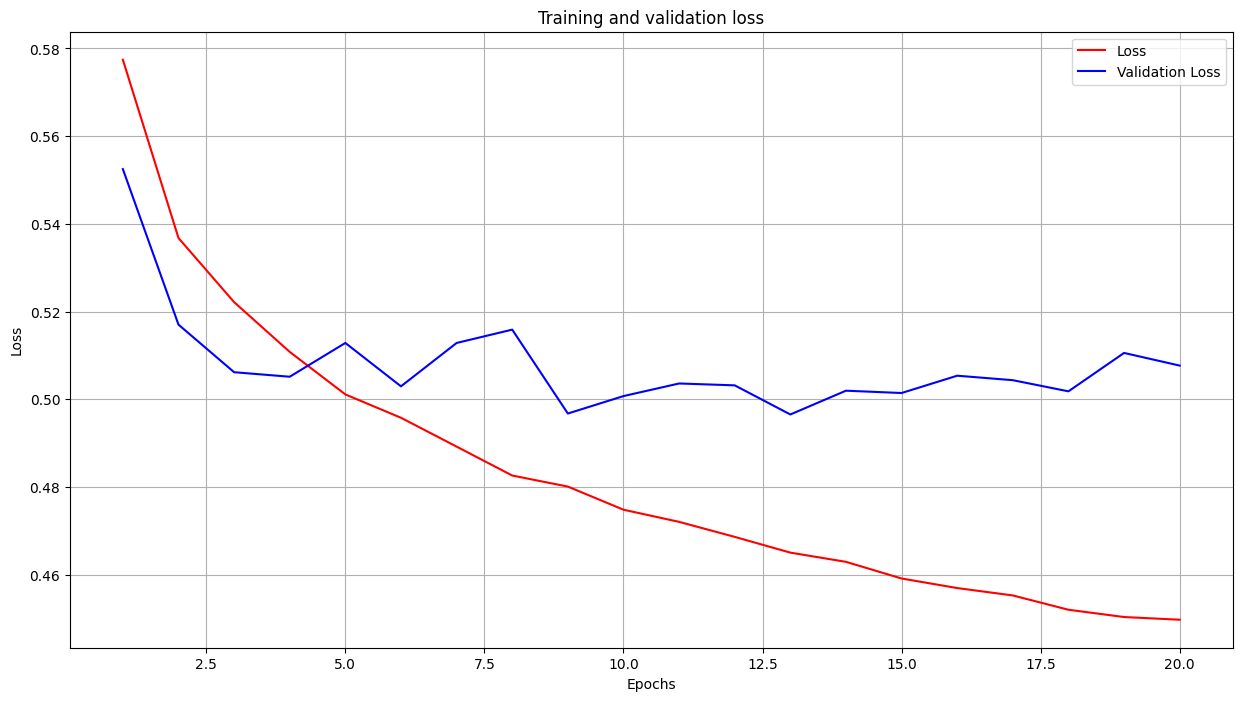

In [46]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = np.arange(1, len(loss) + 1)

plt.figure(figsize=(15, 8))
plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and validation loss')
plt.grid()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])
plt.show()


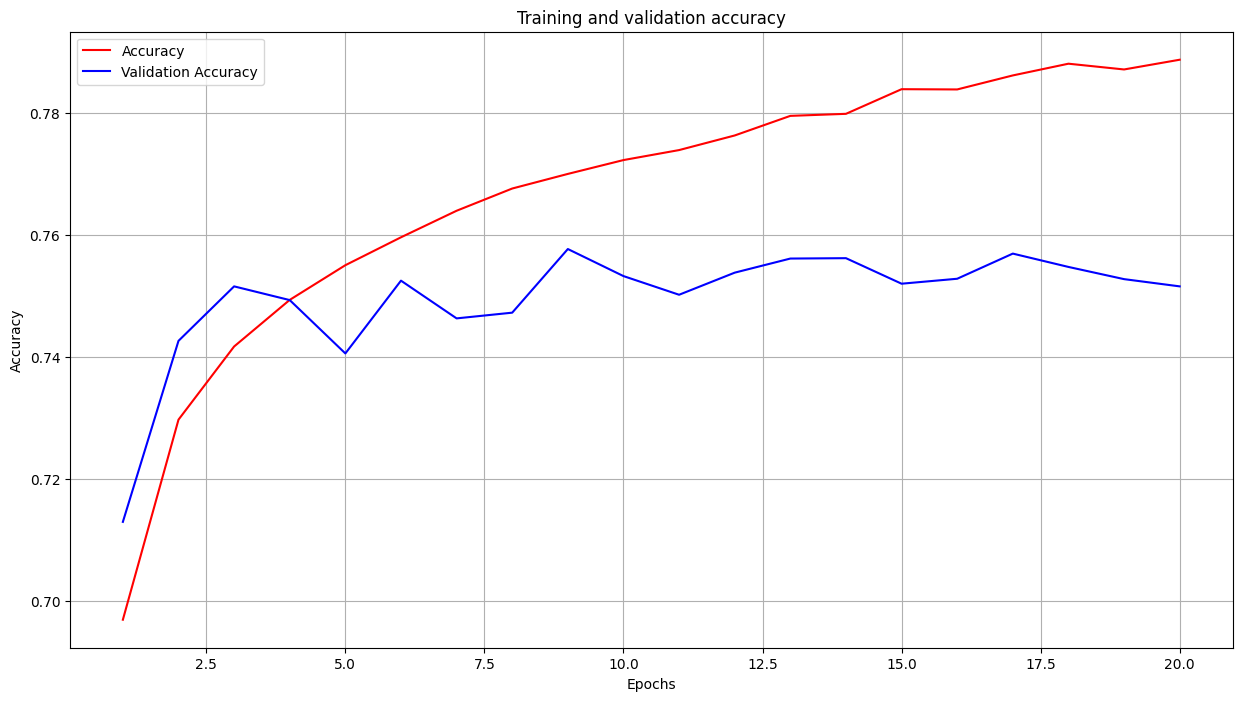

In [47]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.figure(figsize=(15, 8))
plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and validation accuracy')
plt.grid()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Accuracy", "Validation Accuracy"])
plt.show()

In [48]:
preds = model.predict(val_pad_trunc_seq)

500/500 [==============================] - 2s 3ms/step


In [50]:
preds_df = pd.DataFrame(preds, columns=["pred"])
preds_df


,pred
0,0.943480
1,0.649760
2,0.321761
3,0.020683
4,0.056026
...,...
15995,0.404304
15996,0.080315
15997,0.762585
15998,0.619079


In [51]:
preds_df.describe()

,pred
count,16000.000000
mean,0.529230
std,0.311227
min,0.001452
25%,0.255297
50%,0.532777
75%,0.813108
max,0.998245


array([[<Axes: title={'center': 'pred'}>]], dtype=object)

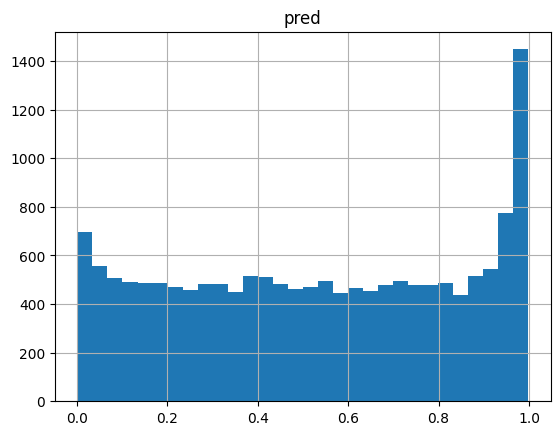

In [60]:
preds_df.hist(bins=30)

In [53]:
from sklearn.metrics import roc_auc_score, classification_report

In [57]:
roc_auc_score(val_labels, preds)

0.8342433766034597

In [64]:
print(classification_report(val_labels, preds_df.pred.round().values))

              precision    recall  f1-score   support

           0       0.76      0.72      0.74      7917
           1       0.74      0.78      0.76      8083

    accuracy                           0.75     16000
   macro avg       0.75      0.75      0.75     16000
weighted avg       0.75      0.75      0.75     16000

